## Part 2： 情感分析项目 

本项目的目标是基于用户提供的评论，通过算法自动去判断其评论是正面的还是负面的情感。比如给定一个用户的评论：
- 评论1： “我特别喜欢这个电器，我已经用了3个月，一点问题都没有！”
- 评论2： “我从这家淘宝店卖的东西不到一周就开始坏掉了，强烈建议不要买，真实浪费钱”

对于这两个评论，第一个明显是正面的，第二个是负面的。 我们希望搭建一个AI算法能够自动帮我们识别出评论是正面还是负面。

情感分析的应用场景非常丰富，也是NLP技术在不同场景中落地的典范。比如对于一个证券领域，作为股民，其实比较关注舆论的变化，这个时候如果能有一个AI算法自动给网络上的舆论做正负面判断，然后把所有相关的结论再整合，这样我们可以根据这些大众的舆论，辅助做买卖的决策。 另外，在电商领域评论无处不在，而且评论已经成为影响用户购买决策的非常重要的因素，所以如果AI系统能够自动分析其情感，则后续可以做很多有意思的应用。 

情感分析是文本处理领域经典的问题。整个系统一般会包括几个模块：
- 数据的抓取： 通过爬虫的技术去网络抓取相关文本数据
- 数据的清洗/预处理：在本文中一般需要去掉无用的信息，比如各种标签（HTML标签），标点符号，停用词等等
- 把文本信息转换成向量： 这也成为特征工程，文本本身是不能作为模型的输入，只有数字（比如向量）才能成为模型的输入。所以进入模型之前，任何的信号都需要转换成模型可识别的数字信号（数字，向量，矩阵，张量...)
- 选择合适的模型以及合适的评估方法。 对于情感分析来说，这是二分类问题（或者三分类：正面，负面，中性），所以需要采用分类算法比如逻辑回归，朴素贝叶斯，神经网络，SVM等等。另外，我们需要选择合适的评估方法，比如对于一个应用，我们是关注准确率呢，还是关注召回率呢？ 

在本次项目中，我们已经给定了训练数据和测试数据，它们分别是 train.positive.txt, train.negative.txt， test_combined.txt. 请注意训练数据和测试数据的格式不一样，详情请见文件内容。 整个项目你需要完成以下步骤：

数据的读取以及清洗： 从给定的.txt中读取内容，并做一些数据清洗，这里需要做几个工作： （1） 文本的读取，需要把字符串内容读进来。 （2）去掉无用的字符比如标点符号，多余的空格，换行符等 （3） 分词
把文本转换成TF-IDF向量： 这部分直接可以利用sklearn提供的TfidfVectorizer类来做。
利用逻辑回归模型来做分类，并通过交叉验证选择最合适的超参数
利用支持向量机做分类，并通过交叉验证选择神经网络的合适的参数

### File Reading: 文本读取 

In [1]:
import pandas as pd
import numpy as np

In [ ]:
#https://blog.csdn.net/u011371629/article/details/91348043
# https://blog.csdn.net/lt326030434/article/details/83383614

In [3]:
import re
import jieba

In [2]:
%config ZMQInteractiveShell.ast_node_interactivity='all'

In [65]:
def read_train_file(file_path):
    comments = []  # 用来存储评论
    labels = []   # 存储标签
    with open(file_path,encoding='utf-8') as file:
        # TODO 提取每一个评论，然后利用process_line函数来做处理，并添加到comments。
        text = file.read().replace(' ','').replace('\n','')
        reg = '<reviewid="\d{1,4}">(.*?)</review>'
        result = re.findall(reg,text)
        for r in result:
            comments.append(r)
            if file_path == 'data/train.positive.txt':
                labels.append('1')
            else:
                labels.append('0')
    return comments, labels

def read_test_file(file_path):
    comments = []  # 用来存储评论
    labels = []   # 存储标签
    with open(file_path,encoding='utf-8') as file:
        # TODO 提取每一个评论，然后利用process_line函数来做处理，并添加到comments。
        text = file.read().replace(' ','').replace('\n','')
        reg = '<reviewid="\d{1,4}".*?</review>'
        result = re.findall(reg,text)
        for r in result:
            label_reg = '<reviewid="\d{1,4}"label="(\d)">'
            com_reg = '>(.*?)</review>'
            label = re.findall(label_reg,r)[0]
            comment = re.findall(com_reg,r)[0]
            labels.append(label)
            comments.append(comment)
    return comments, labels

In [66]:
def process_file():
    """
    读取训练数据和测试数据，并对它们做一些预处理
    解析标签中的内容
    """    
    train_pos_file = "data/train.positive.txt"
    train_neg_file = "data/train.negative.txt"
    test_comb_file = "data/test.combined.txt"
    
    # TODO: 读取文件部分，把具体的内容写入到变量里面
    train__pos_comments,train_pos_labels = read_train_file(train_pos_file)
    
    train__neg_comments,train_neg_labels = read_train_file(train_neg_file)
    
    test_comments,test_labels = read_test_file(test_comb_file)
    return train__pos_comments,train_pos_labels,train_labels,train__neg_comments,train_neg_labels ,test_comments,test_labels

### Explorary Analysis: 做一些简单的可视化分析 

In [67]:
# 训练数据和测试数据大小
train__pos_comments,train_pos_labels,train_labels,train__neg_comments,train_neg_labels ,test_comments,test_labels=process_file()
train_comments=train__pos_comments+train__neg_comments
train_labels=train_pos_labels+train_neg_labels
(len(train_comments), len(train_labels), len(test_comments), len(test_labels))


(8065, 8065, 2500, 2500)

In [68]:
print(train__pos_comments[0])

请问这机不是有个遥控器的吗？


D:\soft\anaconda\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
D:\soft\anaconda\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


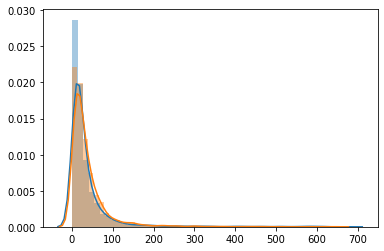

In [69]:
# TODO: 对于训练数据中的正负样本，分别画出一个histogram， histogram的x抽是每一个样本中字符串的长度，y轴是拥有
# 这个长度的样本的百分比。
#       并说出样本长度是否对情感有相关性 (需要先用到结巴分词)
#       参考：https://en.wikipedia.org/wiki/Histogram
import matplotlib.pyplot as plt
import seaborn as sns

def count_sentence(sentences):
    len_list = []
    for s in sentences:
        sentence = []
        for i in jieba.cut(s):
            sentence.append(i)
        len_list.append(len(sentence))
    return len_list
sns.distplot(count_sentence(train__pos_comments))   # train_pos_comments样本中各长度样本所占百分比
sns.distplot(count_sentence(train__neg_comments))   # train_neg_comments样本中各长度样本所占百分比

In [ ]:
# 正负样本长度所占比例基本相近,说明样本长度与情感没有相关性

In [71]:
# TODO： 分别列出训练数据中正负样本里的top 20单词（可以做适当的stop words removal）。 
import collections


def get_top20_words(comments):
    word_library = []   # 储存所有词
    for comment in comments:
        for i in jieba.cut(comment):
            word_library.append(i)
    word_dic = collections.Counter(word_library).most_common(20)
    top20_list = [i[0] for i in word_dic]
    return top20_list
print(get_top20_words(train__pos_comments))
print(get_top20_words(train__neg_comments))

pos_20=get_top20_words(train__pos_comments)
neg_20=get_top20_words(train__neg_comments)
# 将正面评价和负面评价中共同出现的词作为停用词
stop_words = []
for word in get_top20_words(pos_20):
    if word in get_top20_words(neg_20) and word.isalnum():
        stop_words.append(word)
print('stop_words:' + str(stop_words))


['，', '的', '。', '了', '是', '！', '很', ',', '我', '也', '在', '有', '~', '都', '好', '.', '不错', '就', '买', '喜欢']
['，', '的', '。', '了', '！', '是', '我', ',', '不', '买', '就', '也', '都', '很', '有', '在', '？', '没有', '!', '.']
stop_words:['的', '了', '是', '很', '我', '也', '在', '有', '都', '就', '买']


##### Text Cleaning: 文本处理部分 

In [73]:
# TODO：对于train_comments, test_comments进行字符串的处理，几个考虑的点：
#   1. 停用词过滤
#   2. 去掉特殊符号
#   3. 去掉数字（比如价格..)
#   4. ...
#   需要注意的点是，由于评论数据本身很短，如果去掉的太多，很可能字符串长度变成0
#   预处理部分，可以自行选择合适的方.
train_comments_new = [] 
test_comments_new = []
import string

def text_preprocessing(comments):
    comments_new = []
    for comment in comments:
        sentence = ''
        for word in list(jieba.cut(comment)):
            # 去除停用词、标点符号、数字
            if word not in set(stop_words) and word.isalnum() and not word.isdigit():
                sentence += word + ' '
        comments_new.append(sentence)
    return comments_new
    
train_comments_new = text_preprocessing(train_comments)
test_comments_new = text_preprocessing(test_comments)


print(test_comments_new[0])

终于 找到 同道中人 啦 从 初中 开始 已经 喜欢 上 michaeljackson 但 同学 们 用 鄙夷 眼光 看 他们 人为 jackson 样子 古怪 甚至 说 丑 当场 气晕 但 现在 同道中人 好开心 michaeljacksonisthemostsuccessfulsingerintheworld 


### Feature Extraction : 从文本中提取特征 

In [74]:
# TODO: 利用tf-idf从文本中提取特征,写到数组里面. 
#       参考：https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
X_train = tf.fit_transform(train_comments)
y_train = np.array(train_labels)
X_test =   tf.transform(test_comments)
y_test =   np.array(test_labels)

print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

(8065, 43903) (2500, 43903) (8065,) (2500,)


### Modeling: 训练模型以及选择合适的超参数 

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
# TODO： 利用逻辑回归来训练模型
#       1. 评估方式： F1-score
#       2. 超参数（hyperparater）的选择利用grid search https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#       3. 打印出在测试数据中的最好的结果（precision, recall, f1-score, 需要分别打印出正负样本，以及综合的）
#       请注意：做交叉验证时绝对不能用测试数据。 测试数据只能用来最后的”一次性“检验。
#       逻辑回归的使用方法请参考：http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#       对于逻辑回归，经常调整的超参数为： C

parameters = { 'C':np.logspace(-3,3,7)}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
y_predict = clf.predict(X_test)
print(classification_report(y_test, y_predict))

# 打印在训练数据上的准确率
print("训练数据上的准确率为：" + str(clf.score(X_train, y_train)))
# # 打印在测试数据上的准确率
print("测试数据上的准确率为: " + str(clf.score(X_test, y_test)))
test_comment1 = '这个宝贝还是比较不错滴'
test_comment2 = '很不好，太差了'

def process_text(text=''):

    text = ''.join(e for e in text if e.isalnum() and not e.isdigit() and e not in set(stop_words))
    return ', '.join(jieba.cut(text))




# 出现过拟合


D:\soft\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 1000.0}
              precision    recall  f1-score   support

           0       0.75      0.17      0.28      1250
           1       0.53      0.94      0.68      1250

   micro avg       0.56      0.56      0.56      2500
   macro avg       0.64      0.56      0.48      2500
weighted avg       0.64      0.56      0.48      2500

训练数据上的准确率为：0.999008059516429
测试数据上的准确率为: 0.5564


In [95]:
test = []
test.append(process_text(test_comment2))
print(test)
print(tf.transform(test))
print(clf.predict(tf.transform(test)))

['不好, 太, 差']
  (0, 3841)	1.0
['0']


In [83]:
! pip install bayesian-optimization

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [89]:
from sklearn import svm
# TODO： 利用SVM来训练模型
#       1. 评估方式： F1-score
#       2. 超参数（hyperparater）的选择利用grid search https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#       3. 打印出在测试数据中的最好的结果（precision, recall, f1-score, 需要分别打印出正负样本，以及综合的）
#       请注意：做交叉验证时绝对不能用测试数据。 测试数据只能用来最后的”一次性“检验。
#       SVM的使用方法请参考：http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#       对于SVM模型，经常调整的超参数为：C, gamma, kernel
# import sklearn.model_selection as model_selection
# from sklearn.cross_validation import cross_val_score
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':np.logspace(-3,3,7)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
y_predict = clf.predict(X_test)
print(classification_report(y_test, y_predict))


D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma w

D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma w

D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma w

D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\soft\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma w

{'C': 10.0, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.77      0.17      0.28      1250
           1       0.53      0.95      0.68      1250

   micro avg       0.56      0.56      0.56      2500
   macro avg       0.65      0.56      0.48      2500
weighted avg       0.65      0.56      0.48      2500



对于超参数的调整，我们经常使用gridsearch，这也是工业界最常用的方法，但它的缺点是需要大量的计算，所以近年来这方面的研究也成为了重点。 其中一个比较经典的成果为Bayesian Optimization（利用贝叶斯的思路去寻找最好的超参数）。Ryan P. Adams主导的Bayesian Optimization利用高斯过程作为后验概率（posteior distribution）来寻找最优解。 https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf 在下面的练习中，我们尝试使用Bayesian Optimization工具来去寻找最优的超参数。参考工具：https://github.com/fmfn/BayesianOptimization

In [98]:
# TODO: 仍然使用SVM模型，但在这里使用Bayesian Optimization来寻找最好的超参数。 
#       1. 评估方式： F1-score
#       2. 超参数（hyperparater）的选择利用Bayesian Optimization https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#       3. 打印出在测试数据中的最好的结果（precision, recall, f1-score, 需要分别打印出正负样本，以及综合的）
#       请注意：做交叉验证时绝对不能用测试数据。 测试数据只能用来最后的”一次性“检验。
#       SVM的使用方法请参考：http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#       对于SVM模型，经常调整的超参数为：C, gamma, kernel
#       参考Bayesian Optimization开源工具： https://github.com/fmfn/BayesianOptimization

from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.svm import SVC

def svm_cv(C, gamma):
    svm = SVC(C=10 ** C, gamma=10 ** gamma,random_state=1)
    val = cross_val_score(svm,X_train, y_train, cv=5).mean()
    return val

pbounds = {'C':(0,1),'gamma':(2,20)}
svm_bo = BayesianOptimization(svm_cv,pbounds=pbounds)

svm_bo.maximize()


|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  0.6196   |  0.4381   |  4.475    |
|  2        |  0.6196   |  0.9728   |  7.114    |
|  3        |  0.6196   |  0.7211   |  12.65    |
|  4        |  0.6196   |  0.5643   |  19.11    |
|  5        |  0.6196   |  0.907    |  14.32    |
|  6        |  0.6196   |  0.737    |  2.013    |
|  7        |  0.6196   |  0.1078   |  19.99    |
|  8        |  0.6196   |  0.7285   |  2.001    |
|  9        |  0.6196   |  0.5083   |  19.99    |
|  10       |  0.6196   |  0.4991   |  2.037    |
|  11       |  0.6196   |  0.7561   |  19.93    |
|  12       |  0.6196   |  0.08873  |  2.061    |
|  13       |  0.6196   |  0.02516  |  19.98    |
|  14       |  0.6196   |  0.5539   |  2.14     |
|  15       |  0.6196   |  0.04943  |  19.9     |
|  16       |  0.6196   |  0.3102   |  2.007    |
|  17       |  0.6196   |  0.7176   |  19.99    |
|  18       |  0.6196   |  0.2068   |  2.05     |


### 特征: 添加n-gram特征 (10分)
在原有tf-idf特征的基础上，添加n-gram特征（在这里我们使用bi-gram特征）。添加完之后效果是否有提升？ 为什么？

In [99]:
print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_comments)  # 添加完bigram之后的特征
y_train = np.array(train_labels)                    # 
X_test = vectorizer.transform(test_comments)        # 添加完bigram之后的特征
y_test = np.array(test_labels)                      # 



(8065, 43903) (2500, 43903) (8065,) (2500,)


In [105]:
print(np.logspace(-6,10,10))

[1.00000000e-06 5.99484250e-05 3.59381366e-03 2.15443469e-01
 1.29154967e+01 7.74263683e+02 4.64158883e+04 2.78255940e+06
 1.66810054e+08 1.00000000e+10]


In [104]:
## TODO 模型的训练，如上
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
# TODO： 利用逻辑回归来训练模型
#       1. 评估方式： F1-score
#       2. 超参数（hyperparater）的选择利用grid search https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#       3. 打印出在测试数据中的最好的结果（precision, recall, f1-score, 需要分别打印出正负样本，以及综合的）
#       请注意：做交叉验证时绝对不能用测试数据。 测试数据只能用来最后的”一次性“检验。
#       逻辑回归的使用方法请参考：http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#       对于逻辑回归，经常调整的超参数为： C

parameters = { 'C':np.logspace(-6,10,10)}
# parameters={'C':[0.1,0.01,0.21,0.001]}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
y_predict = clf.predict(X_test)
print(classification_report(y_test, y_predict))

# 打印在训练数据上的准确率
print("训练数据上的准确率为：" + str(clf.score(X_train, y_train)))
# # 打印在测试数据上的准确率
print("测试数据上的准确率为: " + str(clf.score(X_test, y_test)))
test_comment1 = '这个宝贝还是比较不错滴'
test_comment2 = '很不好，太差了'

def process_text(text=''):

    text = ''.join(e for e in text if e.isalnum() and not e.isdigit() and e not in set(stop_words))
    return ', '.join(jieba.cut(text))







D:\soft\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 774.2636826811278}
              precision    recall  f1-score   support

           0       0.77      0.17      0.27      1250
           1       0.53      0.95      0.68      1250

   micro avg       0.56      0.56      0.56      2500
   macro avg       0.65      0.56      0.48      2500
weighted avg       0.65      0.56      0.48      2500

训练数据上的准确率为：0.9991320520768754
测试数据上的准确率为: 0.5584


In [ ]:
from sklearn.neural_network import MLPClassifier
import numpy as np

param_hidden_layer_sizes = np.linspace(10, 200, 20)  # 针对参数 “hidden_layer_sizes”, 尝试几个不同的值
param_alphas = np.logspace(-4,1,6)  # 对于参数 "alpha", 尝试几个不同的值

best_hidden_layer_size = param_hidden_layer_sizes[0]
best_alpha = param_alphas[0]

for size in param_hidden_layer_sizes:
    for val in param_alphas:
        # TODO 编写交叉验证的过程，需要做5-fold交叉验证。
        avg = 0
        for train_index, test_index in kf.split(X_train, y_train):
            mlp = MLPClassifier(alpha=int(val),hidden_layer_sizes=int(size))
            mlp.fit(X_train[train_index],y_train[train_index])
            avg += mlp.score(X_train[test_index],y_train[test_index])
        acc_avg = avg/5
        if acc_avg > best_acc:
            best_acc = acc_avg
            best_hidden_layer_size = size
            best_alpha = val

print ("最好的参数hidden_layer_size值为： %f" % (best_hidden_layer_size))
print ("最好的参数alpha值为： %f" % (best_alpha))

# TODO 我们需要在整个训练数据上重新训练模型，但这次使用最好的参数hidden_layer_size和best_alpha
mlp = MLPClassifier(alpha=best_alpha,hidden_layer_sizes=best_hidden_layer_size).fit(X_train,y_train)
# 打印在训练数据上的准确率
print ("训练数据上的准确率为：" + str(mlp.score(X_train, y_train)))

# 打印在测试数据上的准确率
print ("测试数据上的准确率为: " + str(mlp.score(X_test, y_test)))     
